In [80]:
%matplotlib inline 
from ggplot import *
import pandas as pd
from os import listdir

def get_counts(fn):
    return pd.read_csv(fn, header=None, names=["value", "count"])

def load_output_dir(dn):
    retval = {}
    for fn in listdir(dn):
        field = fn[len("unique_"):-1 * len(".csv")]
        #print field
        retval[field] = get_counts("{0}/{1}".format(dn, fn))
        
    return retval
        

In [81]:
#counts = {}
#counts["dwc_genus"] = get_counts("../out/unique_dwc_genus.csv")
#counts["dwc_institutionCode"] = get_counts("../out/unique_dwc_institutionCode.csv")

counts = load_output_dir("../out")

In [82]:
cardinalities = pd.DataFrame(columns=["id", "field", "card"])
i = 0
for k, c in counts.iteritems():
    cardinalities.loc[i] = (i, k, c.shape[0])
    i += 1

cardinalities.sort(columns="card", inplace=True, ascending=False)
cardinalities["id"] = range(0, cardinalities.shape[0])

#print cardinalities

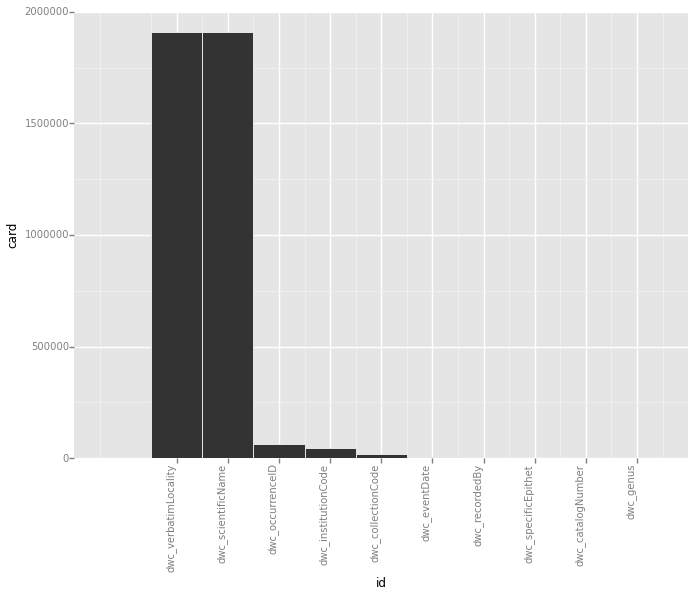

<ggplot: (8785114293989)>

In [83]:
p = ggplot(aes(x="id", y="card"), data=cardinalities) \
+ geom_bar(stat='identity') \
+ theme(axis_text_x  = element_text(angle = 90, hjust = 1)) \
+ scale_x_discrete(breaks=range(0, cardinalities.shape[0]), labels=cardinalities["field"])
p

